## Import All Required Libraries

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sb
from sklearn import metrics
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import math
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sb.set_style("whitegrid")
get_ipython().run_line_magic('matplotlib', 'inline')

# Reading Data File

>Displaying Top 5 Records

In [46]:
csv_file = "E:\Reviews.csv"
df = pd.read_csv(csv_file)
print("Number  of  Products  for  reviews :", len(df["ProductId"].unique()))
print("Number of Unique users for reviews :", len(df["UserId"].unique()))
df.head()

Number  of  Products  for  reviews : 74258
Number of Unique users for reviews : 256059


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Selecting top 100k records for analysis

>So that we can reduce processing time to make it work for slow systems too. You can take all the 568k records if your system is efficient enough

In [47]:
data = df[:100000].copy()
data = data.drop(["Time", "HelpfulnessNumerator", "HelpfulnessDenominator", "ProfileName"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Id         100000 non-null  int64 
 1   ProductId  100000 non-null  object
 2   UserId     100000 non-null  object
 3   Score      100000 non-null  int64 
 4   Summary    99998 non-null   object
 5   Text       100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


In [48]:
data.head()

,Id,ProductId,UserId,Score,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy,Great taffy at a great price. There was a wid...


### Getting only unique Products

In [49]:
asins_unique = len(data["ProductId"].unique())
print(f"Number of Unique Product IDs: {asins_unique}")
print("Unique Products are : ", data["ProductId"].unique())

Number of Unique Product IDs: 12560
Unique Products are :  ['B001E4KFG0' 'B00813GRG4' 'B000LQOCH0' ... 'B0028GY8U2' 'B000KGOTO2'
 'B000LQORDE']


# Ploting Score Graphs

>So that we will get the overview, without calculating number of each score

## Histogram

>This graph is showing how many reviews get a specific score

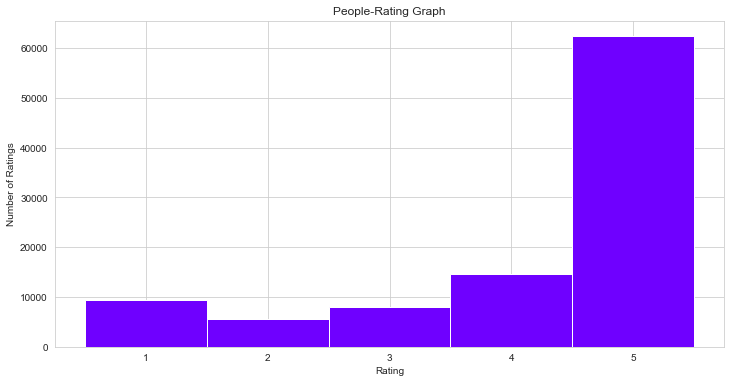

In [50]:
x_axis_rating = data["Score"]
x_axis_rating.hist(bins=[0.5,1.5,2.5,3.5,4.5,5.5], figsize=(12,6), grid=True, color="#6f00ff")

plt.title("People-Rating Graph")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.show()

## Box-Plot

>Box-Plot gives the concentration data distribution

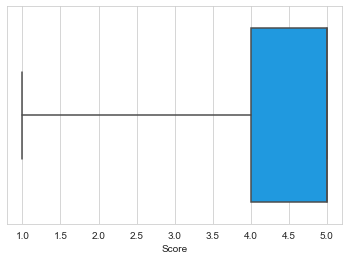

In [51]:
sb.boxplot(x="Score", data=data, whis=5, color="#00a2ff");

## Violin-Plot

>Violin-Plot gives the frequency distribution of the data to visualize how the data is distributed and which points have more concentration of the data

<AxesSubplot:ylabel='Score'>

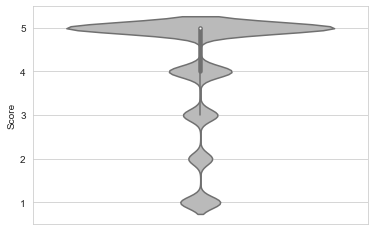

In [52]:
sb.violinplot(y="Score", data=data, bw=0.1, color="#bababa")

### Dropping null values

>Our data does not have any null values, that's why it won't affect data

In [53]:
print(f"Before Removing Null Values: {len(data)}")
dataAfter = data.dropna(subset=["Score"])
print(f"After Removing Null Values: {len(dataAfter)}")
dataAfter["Score"] = dataAfter["Score"].astype(int)

Before Removing Null Values: 100000
After Removing Null Values: 100000


# Splitting data into TRAIN & TEST datasets

>Data is splitted up after shuffling

In [54]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter, dataAfter["Score"]): 
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

>Checking length of the Train dataset and the percentage of each score

In [55]:
len(strat_train)

80000

In [56]:
strat_train["Score"].value_counts()/len(strat_train)

5    0.624125
4    0.146437
1    0.093175
3    0.080588
2    0.055675
Name: Score, dtype: float64

>Checking length of the Test dataset and the percentage of each score

In [57]:
len(strat_test)

20000

In [58]:
strat_test["Score"].value_counts()/len(strat_test)

5    0.6241
4    0.1464
1    0.0932
3    0.0806
2    0.0557
Name: Score, dtype: float64

## Using Shuffled Train Dataset

>Checking the Top 5 Records

In [59]:
reviews = strat_train.copy()
reviews.head()

,Id,ProductId,UserId,Score,Summary,Text
45344,45345,B003GHESE8,AQ52JX9ES6XYY,5,convenience packs ROCK! :),These Walker's Shortbread Fingers in single se...
72377,72378,B001E6K6GW,AE6KNBCR1YCNB,5,Love these nut bars!,"These are some of my favorite nut bars, and ar..."
15490,15491,B000255OIG,A2G1LRD120SJPC,5,Excellent Product and Made in U.S.A.,"My three very finicky dogs love this product, ..."
55038,55039,B000IHJEDE,A1833SGGG68N4N,5,There are a great gluten free snack!,"My daughter does not always want to eat the ""s..."
15508,15509,B000255OIG,A3G8C334EDZPP7,5,Great for Diabetic Dog,These Dried Dog Treats are great. My dog was ...


>Finding Number of Unique Products

In [60]:
unique_pro_ids = len(reviews["ProductId"].unique())
print(f"Number of unique Product IDs in Trained Data Reviews: {unique_pro_ids}")

Number of unique Product IDs in Trained Data Reviews: 11472


>Checking basic info of the Data Frame before further processing

In [61]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 45344 to 145
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         80000 non-null  int64 
 1   ProductId  80000 non-null  object
 2   UserId     80000 non-null  object
 3   Score      80000 non-null  int32 
 4   Summary    80000 non-null  object
 5   Text       80000 non-null  object
dtypes: int32(1), int64(1), object(4)
memory usage: 4.0+ MB


>Finding Mean of all the ratings of train dataset

In [62]:
reviews["Score"].mean()

4.1526625

>Counting Number of reviews of each Product from the Train dataset

In [63]:
counts = reviews["ProductId"].value_counts().to_frame()
counts.head(10)

,ProductId
B002QWP89S,519
B0026RQTGE,504
B0013NUGDE,446
B000KV61FC,444
B007M83302,430
B005ZBZLT4,410
B000PDY3P0,400
B002IEZJMA,386
B002LANN56,383
B004SRH2B6,367


>Calculating the Mean rating score of each Product in the Train Dataset

In [64]:
avg_rating = reviews.groupby("ProductId")["Score"].mean().to_frame()
avg_rating.head(10)

,Score
ProductId,
2734888454,3.500000
B00002N8SM,1.812500
B00002NCJC,4.500000
B00002Z754,5.000000
B00005V3DC,5.000000
B00006IDJO,1.000000
B00006IDJU,5.000000
B000084DVR,5.000000
B000084E1U,5.000000


>Grouping the Product count and the Mean rating of each product in Train Dataset to form a Table

In [65]:
table = counts.join(avg_rating)
table.head(30)

,ProductId,Score
B002QWP89S,519,4.554913
B0026RQTGE,504,4.603175
B0013NUGDE,446,4.298206
B000KV61FC,444,3.423423
B007M83302,430,4.304651
B005ZBZLT4,410,4.356098
B000PDY3P0,400,4.332500
B002IEZJMA,386,3.603627
B002LANN56,383,3.767624
B004SRH2B6,367,3.662125


## Scatter Plot

>Scatter plots are used to observe relationships between variables. The dots in a scatter plot not only report the values of individual data points, but also patterns when the data are taken as a whole. Here, we can conclude that the number of times a product being purchased is affecting it's rating either in a good or a bad way. 

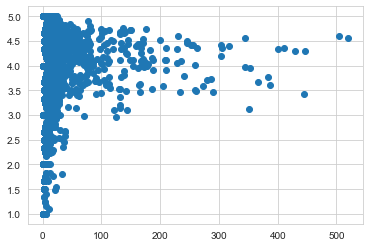

In [66]:
plt.scatter("ProductId", "Score", data=table);

### Classifying the review on the basis of rating

In [67]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"

strat_train["Sentiment"] = strat_train["Score"].apply(sentiments)
strat_test["Sentiment"] = strat_test["Score"].apply(sentiments)
strat_train["Sentiment"][:10]

45344    Positive
72377    Positive
15490    Positive
55038    Positive
15508    Positive
12925     Neutral
61204    Negative
12452    Negative
55631    Positive
70478    Positive
Name: Sentiment, dtype: object

## Calculating Algos' Metrics

#### Calculating Precision, Recall and F-Score of the Algorithm using TP,TN,FP,FN

In [68]:
# Calculating other metrics

def calculate_precision(conf_mat):
    return (conf_mat[2][2]) / (conf_mat[2][2] + conf_mat[2][0])


def calculate_recall(conf_mat):
    return (conf_mat[2][2]) / (conf_mat[2][2] + conf_mat[0][2])


def calculate_f_score(algo_precision, algo_recall):
    return (2*(algo_precision * algo_recall)) / (algo_precision + algo_recall)

## Pre-Processing Data

>Checking Number of Samples

In [69]:
X_train = strat_train["Text"]
X_train_targetSentiment = strat_train["Sentiment"]
X_test = strat_test["Text"]
X_test_targetSentiment = strat_test["Sentiment"]
print(f"Number of Training Samples: {len(X_train)}")
print(f"Number of Test Data Samples: {len(X_test)}")

Number of Training Samples: 80000
Number of Test Data Samples: 20000


> 1 - Filling NA's with EMPTY STRING <br> 2 - Transforming data to Count Vectors - The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words <br> 3 - Getting Number of  Samples and the Distinct Words

In [70]:
X_train = X_train.fillna(' ')
X_test = X_test.fillna(' ')
X_train_targetSentiment = X_train_targetSentiment.fillna(' ')
X_test_targetSentiment = X_test_targetSentiment.fillna(' ')

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape
print(f"Number of Training Samples: {X_train_counts.shape[0]}")
print(f"Number of Distinct Words: {X_train_counts.shape[1]}")

Number of Training Samples: 80000
Number of Distinct Words: 51032


### DF-IDF Transformation

>1 - Stop Word Removal <br> 2 - PoS tagging <br> 3 - We have already tokenize data using CountVectorizer. By using Stop word removal, POS tagging etc. we may not analyse the data correctly because some of the important words that distinguish the class of data get removed. That's why we are using TF-IDF transformation that will automatically assign less weight to unimportant words and the important words or the class distinguishers won't get removed.  Moreover, visit https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/ for detailed explanation

In [71]:
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape
print(f"Number of Training Samples: {X_train_tfidf.shape[0]}")
print(f"Number of Distinct Words: {X_train_tfidf.shape[1]}")

Number of Training Samples: 80000
Number of Distinct Words: 51032


# Applying Classification Algorithms

## Multinominal Niave Bayes

>It calculates the probability of an occurence based on the training / prior data. It is based on Bayes theorem. For more details visit https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [72]:
# Multinominal Niave Bayes
clf_multiNB_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_nominalNB", MultinomialNB())])
clf_multiNB_pipe.fit(X_train, X_train_targetSentiment)

predictedMultiNB = clf_multiNB_pipe.predict(X_test)
np.mean(predictedMultiNB == X_test_targetSentiment)

0.7737

>Classification Report and Accuracy Score

In [73]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedMultiNB)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedMultiNB)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.92      0.02      0.04      2978
     Neutral       0.00      0.00      0.00      1612
    Positive       0.77      1.00      0.87     15410

    accuracy                           0.77     20000
   macro avg       0.56      0.34      0.31     20000
weighted avg       0.73      0.77      0.68     20000

Accuracy: 0.7737


>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [74]:
conf_arr_mnb = metrics.confusion_matrix(X_test_targetSentiment, predictedMultiNB)
conf_arr_mnb

array([[   68,     0,  2910],
       [    2,     0,  1610],
       [    4,     0, 15406]], dtype=int64)

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [75]:
total_precision = calculate_precision(conf_arr_mnb)
total_recall = calculate_recall(conf_arr_mnb)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.999740428293316
Recall  of the   Algorithm :  0.8411225158331513
F-Score  of the  Algorithm :  0.9135978177074068


## Logistic Regression Classifier

>It computes the probability of an event occurrence. It classify the text according its probability. for more details visit https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

In [76]:
# Logistic Regression Classifier
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression())])
clf_logReg_pipe.fit(X_train, X_train_targetSentiment)

predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == X_test_targetSentiment)

0.8601

>Classification Report and Accuracy Score

In [77]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedLogReg)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedLogReg)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.76      0.65      0.70      2978
     Neutral       0.51      0.18      0.27      1612
    Positive       0.89      0.97      0.93     15410

    accuracy                           0.86     20000
   macro avg       0.72      0.60      0.63     20000
weighted avg       0.84      0.86      0.84     20000

Accuracy: 0.8601


>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [78]:
conf_arr_lrg = metrics.confusion_matrix(X_test_targetSentiment, predictedLogReg)
conf_arr_lrg

array([[ 1929,   132,   917],
       [  342,   291,   979],
       [  281,   147, 14982]], dtype=int64)

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [79]:
total_precision = calculate_precision(conf_arr_lrg)
total_recall = calculate_recall(conf_arr_lrg)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.9815894647186005
Recall  of the   Algorithm :  0.9423234165670797
F-Score  of the  Algorithm :  0.9615557409665618


## Support Vector Machine Classifier

>The classifier separates data points using a hyperplane with the largest amount of margin. SVM finds an optimal hyperplane which helps in classifying new data points. For more details, visit https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

In [80]:
# Support Vector Machine Classifier
clf_linearSVC_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train, X_train_targetSentiment)

predictedLinearSVC = clf_linearSVC_pipe.predict(X_test)
np.mean(predictedLinearSVC == X_test_targetSentiment)

0.86295

>Classification Report and Accuracy Score

In [81]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedLinearSVC)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedLinearSVC)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.73      0.69      0.71      2978
     Neutral       0.50      0.22      0.30      1612
    Positive       0.90      0.96      0.93     15410

    accuracy                           0.86     20000
   macro avg       0.71      0.62      0.65     20000
weighted avg       0.84      0.86      0.85     20000

Accuracy: 0.86295


>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [82]:
conf_arr_svm = metrics.confusion_matrix(X_test_targetSentiment, predictedLinearSVC)
conf_arr_svm

array([[ 2051,   162,   765],
       [  372,   349,   891],
       [  370,   181, 14859]], dtype=int64)

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [83]:
total_precision = calculate_precision(conf_arr_svm)
total_recall = calculate_recall(conf_arr_svm)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.9757042484733075
Recall  of the   Algorithm :  0.951036866359447
F-Score  of the  Algorithm :  0.9632126535507082


## Decision Tree Classifier

>A decision tree is a flowchart-like tree structure where an internal node represents feature, the branch represents a decision rule, and each leaf node represents the outcome. For more details visit https://www.datacamp.com/community/tutorials/decision-tree-classification-python

In [84]:
# Decision Tree Classifier
clf_decisionTree_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), 
                                  ("clf_decisionTree", DecisionTreeClassifier())])
clf_decisionTree_pipe.fit(X_train, X_train_targetSentiment)

predictedDecisionTree = clf_decisionTree_pipe.predict(X_test)
np.mean(predictedDecisionTree == X_test_targetSentiment)

0.7795

>Classification Report and Accuracy Score

In [85]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedDecisionTree)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedDecisionTree)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.51      0.50      0.50      2978
     Neutral       0.34      0.30      0.32      1612
    Positive       0.87      0.88      0.88     15410

    accuracy                           0.78     20000
   macro avg       0.57      0.56      0.57     20000
weighted avg       0.77      0.78      0.78     20000

Accuracy: 0.7795


>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [86]:
conf_arr_dct = metrics.confusion_matrix(X_test_targetSentiment, predictedDecisionTree)
conf_arr_dct

array([[ 1481,   245,  1252],
       [  331,   487,   794],
       [ 1080,   708, 13622]], dtype=int64)

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [87]:
total_precision = calculate_precision(conf_arr_dct)
total_recall = calculate_recall(conf_arr_dct)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.9265406067201741
Recall  of the   Algorithm :  0.9158262740352292
F-Score  of the  Algorithm :  0.9211522856370029


## Random Forest Classifier

>Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. For more details visit https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [88]:
# Random Forest Classifier
clf_randomForest_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_randomForest", RandomForestClassifier())])
clf_randomForest_pipe.fit(X_train, X_train_targetSentiment)

predictedRandomForest = clf_randomForest_pipe.predict(X_test)
np.mean(predictedRandomForest == X_test_targetSentiment)

0.8183

>Classification Report and Accuracy Score

In [89]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedRandomForest)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedRandomForest)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.98      0.23      0.38      2978
     Neutral       1.00      0.16      0.28      1612
    Positive       0.81      1.00      0.89     15410

    accuracy                           0.82     20000
   macro avg       0.93      0.47      0.52     20000
weighted avg       0.85      0.82      0.77     20000

Accuracy: 0.8183


>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [90]:
conf_arr_rfc = metrics.confusion_matrix(X_test_targetSentiment, predictedRandomForest)
conf_arr_rfc

array([[  699,     0,  2279],
       [    9,   262,  1341],
       [    5,     0, 15405]], dtype=int64)

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [91]:
total_precision = calculate_precision(conf_arr_rfc)
total_recall = calculate_recall(conf_arr_rfc)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.999675535366645
Recall  of the   Algorithm :  0.8711264419814522
F-Score  of the  Algorithm :  0.930984468483713


## Grid Search CV

In [92]:
# Grid Search CV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],    
             'tfidf__use_idf': (True, False), 
             } 
gs_clf_LinearSVC_pipe = GridSearchCV(clf_linearSVC_pipe, parameters, n_jobs=-1)
gs_clf_LinearSVC_pipe = gs_clf_LinearSVC_pipe.fit(X_train, X_train_targetSentiment)
new_text = ["The headphones are really good, I will buy some more products online from amazon.", 
            "The phone is ok, but it works fine.", 
            "The handfree is not good, does not work very well.", "The iphone is not good", "This TV is so good and is on cheap price."] 

gs_clf_LinearSVC_pipe.predict(new_text)

array(['Positive', 'Neutral', 'Negative', 'Negative', 'Positive'],
      dtype=object)

In [93]:
predictedGS_clf_LinearSVC_pipe = gs_clf_LinearSVC_pipe.predict(X_test)
np.mean(predictedGS_clf_LinearSVC_pipe == X_test_targetSentiment)

0.8933

In [94]:
for performance_analysis in (gs_clf_LinearSVC_pipe.best_score_, 
                             gs_clf_LinearSVC_pipe.best_estimator_, 
                             gs_clf_LinearSVC_pipe.best_params_):
        print(performance_analysis)

0.8882875
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()), ('clf_linearSVC', LinearSVC())])
{'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


>Classification Report and Accuracy Score

In [95]:
# classification_report and accuracy_score
print("Classification Report")
print(f"{classification_report(X_test_targetSentiment, predictedGS_clf_LinearSVC_pipe)}")
print(f"Accuracy: {accuracy_score(X_test_targetSentiment, predictedGS_clf_LinearSVC_pipe)}")

Classification Report
              precision    recall  f1-score   support

    Negative       0.80      0.76      0.78      2978
     Neutral       0.67      0.34      0.45      1612
    Positive       0.92      0.98      0.95     15410

    accuracy                           0.89     20000
   macro avg       0.80      0.69      0.73     20000
weighted avg       0.88      0.89      0.88     20000

Accuracy: 0.8933


>Confusion Matrix (Rows | Columns : Negative, Neutral, Positive)

In [96]:
conf_arr_gs = metrics.confusion_matrix(X_test_targetSentiment, predictedGS_clf_LinearSVC_pipe)
conf_arr_gs

array([[ 2253,   141,   584],
       [  351,   547,   714],
       [  216,   128, 15066]], dtype=int64)

> Calculating metrics for algorithm as a whole <br> 1 - Precision <br> 2 - Recall <br> 3 - F1-Score 

In [97]:
total_precision = calculate_precision(conf_arr_gs)
total_recall = calculate_recall(conf_arr_gs)
total_f_score = calculate_f_score(total_precision, total_recall)

print("Precision of the Algorithm : ", total_precision)
print("Recall  of the   Algorithm : ", total_recall)
print("F-Score  of the  Algorithm : ", total_f_score)

Precision of the Algorithm :  0.9858657243816255
Recall  of the   Algorithm :  0.9626837060702875
F-Score  of the  Algorithm :  0.9741368162420794


In [98]:
dataset = data[:].copy()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Id         100000 non-null  int64 
 1   ProductId  100000 non-null  object
 2   UserId     100000 non-null  object
 3   Score      100000 non-null  int64 
 4   Summary    99998 non-null   object
 5   Text       100000 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


## Getting the overview of the data once again

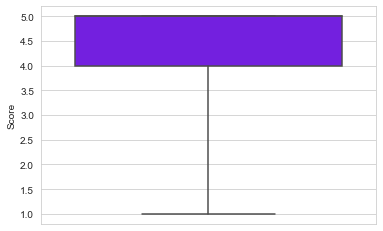

In [99]:
sb.boxplot(y="Score", data=dataset, whis=5, color="#6f00ff");